### Importing libraries

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

### Ingesting Data

In [2]:
train = pd.read_csv('datasets/train.csv', index_col='Id', keep_default_na=False,
                                                       # na_values=
                                                        )
test =  pd.read_csv('datasets/test.csv', index_col='Id', keep_default_na=False,
                                                        #na_values=
                                                        )

train = pd.concat([train, test])

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500.0
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500.0
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500.0
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000.0


### Changing Types

In [3]:
def clean_data(train):
    # Replace all instances of "NA" with "0" in column: 'LotFrontage'
    train['LotFrontage'] = train['LotFrontage'].str.replace("NA", "0", case=False, regex=False)
    # Change column type to float64 for column: 'LotFrontage'
    train = train.astype({'LotFrontage': 'float64'})
    # Change column type to category for column: 'MSSubClass'
    # train = train.astype({'MSSubClass': 'category'})
    # Change column type to category for column: 'MSZoning'
    # train = train.astype({'MSZoning': 'category'})
    # Change column type to category for column: 'Street'
    # train = train.astype({'Street': 'category'})
    # Change column type to category for columns: 'Alley', 'LotShape' and 14 other columns
    # train = train.astype({'Alley': 'category', 'LotShape': 'category', 'LandContour': 'category', 'Utilities': 'category', 'LotConfig': 'category', 'LandSlope': 'category', 'Neighborhood': 'category', 'Condition1': 'category', 'Condition2': 'category', 'BldgType': 'category', 'HouseStyle': 'category', 'RoofStyle': 'category', 'RoofMatl': 'category', 'Exterior1st': 'category', 'MasVnrType': 'category', 'Exterior2nd': 'category'})
    # Replace all instances of 0 with -0.1 in column: 'LotFrontage'
    train.loc[train['LotFrontage'] == 0, 'LotFrontage'] = np.nan
    # Replace all instances of "na" with "0" in column: 'MasVnrArea'
    train['MasVnrArea'] = train['MasVnrArea'].str.replace("na", "0", case=False, regex=False)
    # Change column type to float64 for column: 'MasVnrArea'
    train = train.astype({'MasVnrArea': 'float64'})
    # Change column type to category for columns: 'ExterQual', 'ExterCond' and 21 other columns
    # train = train.astype({'ExterQual': 'category', 'ExterCond': 'category', 'Foundation': 'category', 'BsmtQual': 'category', 'BsmtCond': 'category', 'BsmtExposure': 'category', 'BsmtFinType1': 'category', 'BsmtFinType2': 'category', 'Heating': 'category', 'HeatingQC': 'category', 'CentralAir': 'category', 'Electrical': 'category', 'KitchenQual': 'category', 'Functional': 'category', 'FireplaceQu': 'category', 'GarageType': 'category', 'GarageFinish': 'category', 'GarageQual': 'category', 'GarageCond': 'category', 'PavedDrive': 'category', 'PoolQC': 'category', 'Fence': 'category', 'MiscFeature': 'category'})
    # Change column type to category for columns: 'SaleType', 'SaleCondition'
    # train = train.astype({'SaleType': 'category', 'SaleCondition': 'category','GarageYrBlt': 'category',
                        #   'YearRemodAdd': 'category','YearBuilt': 'category','YrSold': 'category',
                        #   'OverallQual': 'category','OverallCond': 'category','MoSold': 'category'})
    return train

train_clean = clean_data(train.copy())
train_clean.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000.0


In [4]:
test_clean = clean_data(test.copy())
test_clean.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NA,Reg,Lvl,AllPub,Inside,...,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NA,IR1,HLS,AllPub,Inside,...,144,0,NA,NA,NA,0,1,2010,WD,Normal


### Ingesting Description Data

In [5]:
data_description = pd.read_csv('datasets/data_description.txt',
                                sep=r'[\t:]',
                                na_filter=False,
                                header=None,
                                names = ['variable','description'],
                                # na_values= ['UNK'],
                                on_bad_lines='skip',
                                skip_blank_lines=False,
                                skipinitialspace=False,
                                # iterator=True,
                                # chunksize=1
                                

)
data_description.drop(axis='rows', index=373, inplace=True )


<ipython-input-5-8b1524159720>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_description = pd.read_csv('datasets/data_description.txt',


In [6]:
data_description 

,variable,description
0,MSSubClass,Identifies the type of dwelling involved in t...
1,20,1-STORY 1946 & NEWER ALL STYLES
2,30,1-STORY 1945 & OLDER
3,40,1-STORY W/FINISHED ATTIC ALL AGES
4,45,1-1/2 STORY - UNFINISHED ALL AGES
...,...,...
469,Abnorml,"Abnormal Sale - trade, foreclosure, short sale"
470,AdjLand,Adjoining Land Purchase
471,Alloca,Allocation - two linked properties with...
472,Family,Sale between family members


In [7]:
breaks = data_description.query('description.isna()').index.to_list()
vars = []

for brk in breaks:
    vars.append(data_description.at[brk+1, 'variable'] )

vars.insert(0, data_description.at[0, 'variable'])
data_description.insert(1, 'category', 'see')

In [8]:
i=0
x=0
for brk in breaks:
    data_description.loc[i: brk, 'category'] = vars[x]
    i=breaks[x]+1
    x+=1
    if brk==462:
        data_description.loc[brk:, 'category'] = vars[x]
        break

data_description.loc[data_description['category'] == "see", 'category'] = "SaleCondition"

data_description.drop(breaks, axis=0, inplace=True)
data_description


,variable,category,description
0,MSSubClass,MSSubClass,Identifies the type of dwelling involved in t...
1,20,MSSubClass,1-STORY 1946 & NEWER ALL STYLES
2,30,MSSubClass,1-STORY 1945 & OLDER
3,40,MSSubClass,1-STORY W/FINISHED ATTIC ALL AGES
4,45,MSSubClass,1-1/2 STORY - UNFINISHED ALL AGES
...,...,...,...
469,Abnorml,SaleCondition,"Abnormal Sale - trade, foreclosure, short sale"
470,AdjLand,SaleCondition,Adjoining Land Purchase
471,Alloca,SaleCondition,Allocation - two linked properties with...
472,Family,SaleCondition,Sale between family members


In [9]:
desc = data_description.query('variable == category').index
data_description.drop(desc, inplace=True  )


In [10]:
na = list(data_description.query("variable.str.strip() == 'NA' ").category.values)
na


['Alley',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [11]:
n_na= list(set(train_clean.columns.to_list()).difference(set(na)))
n_na

['HeatingQC',
 'BsmtHalfBath',
 'BsmtFinSF2',
 'Street',
 'Fireplaces',
 'TotRmsAbvGrd',
 'SaleCondition',
 'ExterQual',
 'EnclosedPorch',
 'BsmtFullBath',
 'KitchenQual',
 '1stFlrSF',
 'MSZoning',
 'MoSold',
 'BedroomAbvGr',
 'LandContour',
 'LandSlope',
 'OverallCond',
 'ScreenPorch',
 'MiscVal',
 'HouseStyle',
 'GarageYrBlt',
 'BsmtUnfSF',
 'Foundation',
 'LowQualFinSF',
 'RoofStyle',
 'BldgType',
 '3SsnPorch',
 'HalfBath',
 'OverallQual',
 'TotalBsmtSF',
 'Heating',
 'ExterCond',
 'GarageCars',
 'Neighborhood',
 'LotConfig',
 'SalePrice',
 'YearRemodAdd',
 'Exterior1st',
 'FullBath',
 'SaleType',
 'PoolArea',
 'Functional',
 'KitchenAbvGr',
 'GrLivArea',
 'WoodDeckSF',
 'LotArea',
 'GarageArea',
 'CentralAir',
 'LotFrontage',
 '2ndFlrSF',
 'Exterior2nd',
 'LotShape',
 'Condition2',
 'MasVnrType',
 'Electrical',
 'PavedDrive',
 'Condition1',
 'YearBuilt',
 'BsmtFinSF1',
 'RoofMatl',
 'MasVnrArea',
 'OpenPorchSF',
 'MSSubClass',
 'YrSold',
 'Utilities']

## Find and Set Missing

In [12]:

for col in n_na:
    if train_clean[col].eq('NA').sum() > 0:
        print(col)
        train_clean.loc[train_clean[col] == 'NA', col] = None
    # else:




BsmtHalfBath
BsmtFinSF2
BsmtFullBath
KitchenQual
MSZoning
GarageYrBlt
BsmtUnfSF
TotalBsmtSF
GarageCars
Exterior1st
SaleType
Functional
GarageArea
Exterior2nd
MasVnrType
Electrical
BsmtFinSF1
Utilities


In [13]:
train_clean

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,6,2006,WD,Normal,NaN
2916,160,RM,21.0,1894,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,4,2006,WD,Abnorml,NaN
2917,20,RL,160.0,20000,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2006,WD,Abnorml,NaN


## Missing Data

In [14]:
def check_missing(df=train_clean):
    missing = df.isna().sum()
    missing_data = missing[missing > 0]
    return missing_data

check_missing()

MSZoning           4
LotFrontage      486
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SaleType           1
SalePrice       1459
dtype: int64

<Axes: >

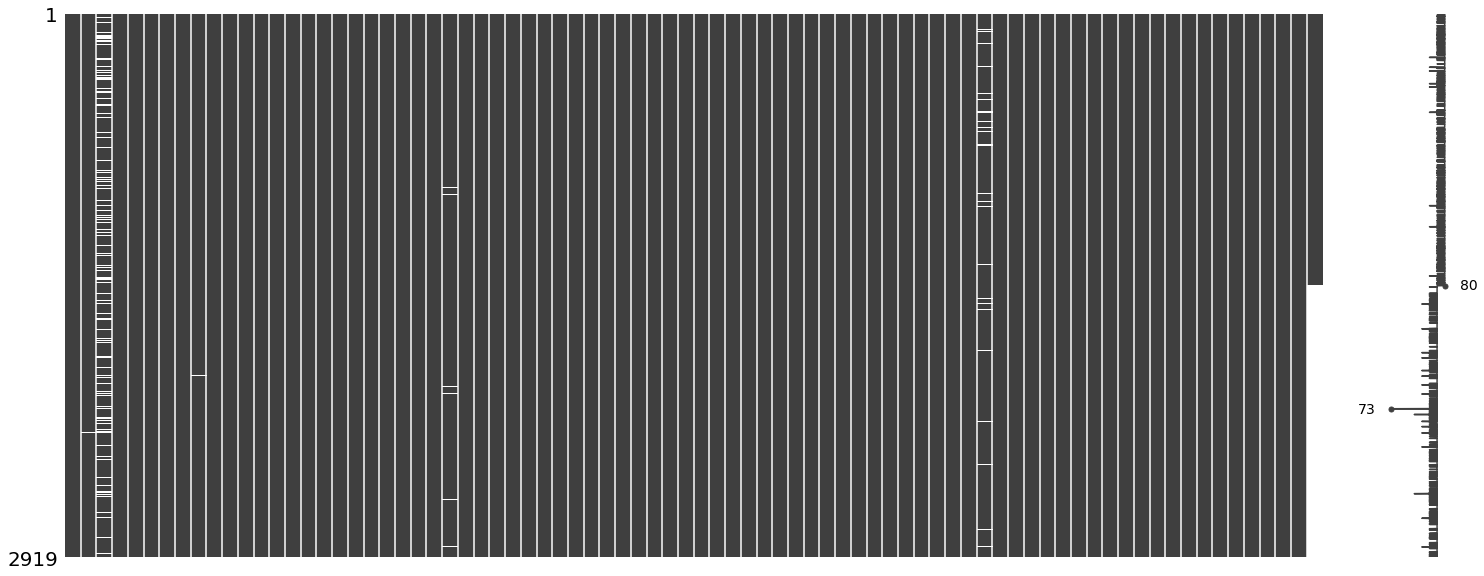

In [15]:
msno.matrix(train_clean)

<Axes: >

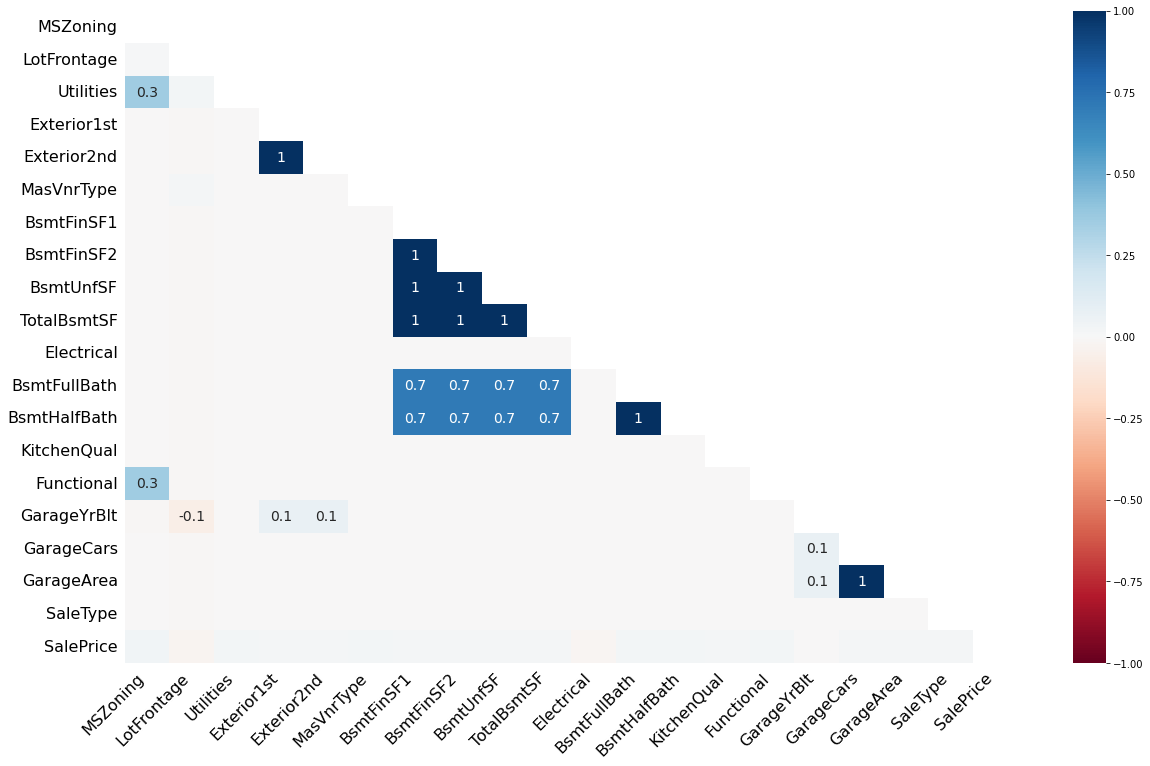

In [16]:
msno.heatmap(train_clean)

# Fill Missing Data

### YearBuilt

In [17]:
corr = train_clean[["GarageYrBlt", "YearBuilt"]].corr()
corr

,GarageYrBlt,YearBuilt
GarageYrBlt,1.000000,0.834812
YearBuilt,0.834812,1.000000


In [18]:
train_clean["GarageYrBlt"].fillna(train_clean["YearBuilt"],inplace=True)
test_clean["GarageYrBlt"].fillna(test_clean["YearBuilt"],inplace=True)


## LotFrontage

In [19]:
check_missing()

MSZoning           4
LotFrontage      486
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageCars         1
GarageArea         1
SaleType           1
SalePrice       1459
dtype: int64

c:\Users\gylbt\anaconda3\envs\ml.venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


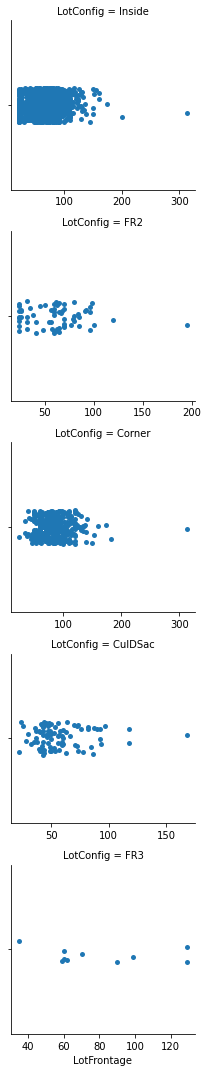

In [20]:
sns.catplot(data=train_clean, x='LotFrontage',kind='strip', row='LotConfig', sharex=False,height=3,orient='portrait')

plt.show()


In [21]:
lot_front_dic = train_clean.mask(train_clean.LotFrontage.isna()) \
            .groupby('LotConfig') \
                ['LotFrontage'].median().round() \
                .to_dict()

lot_front_dic

{'Corner': 80.0, 'CulDSac': 50.0, 'FR2': 62.0, 'FR3': 66.0, 'Inside': 66.0}

In [22]:
# missing_LF = train_clean[(train_clean.LotConfig == key) & (train_clean.LotFrontage.isna())]  

for key, item in lot_front_dic.items():
    train_clean.loc[(train_clean.LotConfig==key ) & (train_clean.LotFrontage.isna()), 'LotFrontage'] = item
    test_clean.loc[(test_clean.LotConfig==key ) & (test_clean.LotFrontage.isna()), 'LotFrontage'] = item

In [23]:
train_clean.MasVnrType.fillna('None', inplace=True)

In [24]:
train_clean.Electrical.fillna(method='pad', inplace=True)

In [25]:
check_missing(train_clean)

MSZoning           4
Utilities          2
Exterior1st        1
Exterior2nd        1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageCars         1
GarageArea         1
SaleType           1
SalePrice       1459
dtype: int64

# Convert Numeric Strings to Floats

In [26]:
for col in train_clean.select_dtypes('object').columns:
    if train_clean[col].str.isnumeric().sum() > 10:
        print(col)
        train_clean[col] = train_clean[col].astype('float64')

BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
BsmtFullBath
BsmtHalfBath
GarageYrBlt
GarageCars
GarageArea


# Drop Missing

### Drop Columns Dominated by a certain value

In [27]:
# unbalanced_cols = []
# for col in train_clean.select_dtypes('object').columns:
#     value_counts = train_clean[col].value_counts(normalize=True)

#     max = value_counts.max()
    
#     print(value_counts)
#    # print(max)

#     if max > .70:
#         unbalanced_cols.append(col)


In [28]:
# train_clean.drop(unbalanced_cols, axis='columns',inplace=True)
# check_missing()

In [29]:
train_clean.SalePrice.fillna(0, inplace=True)
train_clean.dropna(axis=0,inplace=True)
print(train_clean.shape)
check_missing()

(2907, 80)


Series([], dtype: int64)

# Feature Importance

## Correlation of Predictors with Target Variables

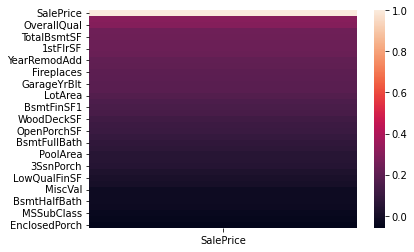

In [30]:
# def plot_correlation_heatmap(target_col: str or None):

#     corr_data: pd.DataFrame
    
#     if target_col is None:
corr_price = train_clean.corr(method='pearson', numeric_only=True)['SalePrice'].sort_values(ascending=False)
#     elif isinstance(target_col, str):
#         corr_data = train_clean.corr(method='pearson')

sns.heatmap(corr_price.to_frame())
plt.show()

# plot_correlation_heatmap('SalePrice')

## Correlation between Predictor Variables (Multicollinearity)

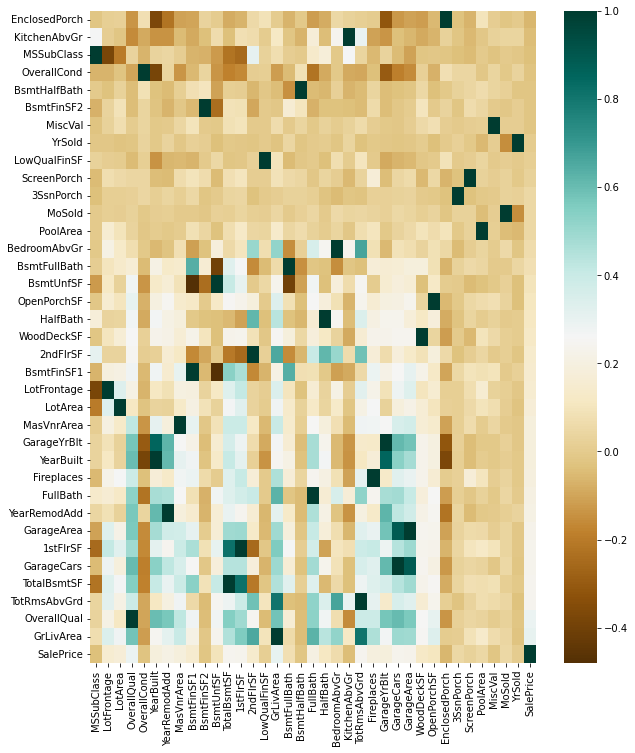

In [31]:
corr_df = train_clean.corr(method='pearson', numeric_only=True).sort_values(by='SalePrice')
fig = plt.figure(figsize=(10,12))
sns.heatmap(corr_df,cmap='BrBG', figure=fig )
plt.show()

In [32]:
corr_df.index


Index(['EnclosedPorch', 'KitchenAbvGr', 'MSSubClass', 'OverallCond',
       'BsmtHalfBath', 'BsmtFinSF2', 'MiscVal', 'YrSold', 'LowQualFinSF',
       'ScreenPorch', '3SsnPorch', 'MoSold', 'PoolArea', 'BedroomAbvGr',
       'BsmtFullBath', 'BsmtUnfSF', 'OpenPorchSF', 'HalfBath', 'WoodDeckSF',
       '2ndFlrSF', 'BsmtFinSF1', 'LotFrontage', 'LotArea', 'MasVnrArea',
       'GarageYrBlt', 'YearBuilt', 'Fireplaces', 'FullBath', 'YearRemodAdd',
       'GarageArea', '1stFlrSF', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd',
       'OverallQual', 'GrLivArea', 'SalePrice'],
      dtype='object')

## Drop highly correlated independent variables

In [33]:
# corrTol = 0.65

# for col in corr_df:
#     if col in corr_df.keys():
#         thisCol = []
#         thisVars = []

#         for i in range(len(corr_df)):
#             if abs(corr_df[col][i]) == 1.0 and col != corr_df.keys()[i]:
#                 thisCorr = 0
#             else:
#                 thisCorr = ( 1 if abs(corr_df[col][i]) > corrTol else -1)
            
#             thisCol.append(thisCorr)
#             thisVars.append(corr_df.keys()[i])
        
#         mask = np.ones(len(thisCol), dtype=bool)

#         ctDelCol = 0

#         for n, j in enumerate(thisCol):
#             # is the correlation greater than 0not equal to the max corr and greater than ze
#             mask[n] = not (j != max(thisCol) and j>=0)

#             if j != max(thisCol) and j >= 0:
#                 corr_df.pop('%s' %thisVars[n])
#                 train_clean.pop('%s' %thisVars[n])
#                 ctDelCol += 1

#         corr_df = corr_df[mask]

In [34]:
# cols_del = []
# tol = .65

# for col, row in corr_df.iterrows():
#     # print(col)
#     # print(row)
#     # print(f"Current column {col}")
#     for col2, corr in row.items():
#         # print(f"Checking correlation with {col2}")
#         if abs(corr) > tol and col2 != col:
#             # print(f"Correlation of {corr} is greater than the tolerance of {tol}")
#             # print("Adding it to deleted columns")
#             corr_target = corr_df.loc[col, 'SalePrice']
#             corr_target2 = corr_df.loc[col2, 'SalePrice']
#             if corr_target > corr_target2:
#                 cols_del.append(col2)
#             else:
#                 cols_del.append(col)

# cols_del = list(set(cols_del))


In [35]:
# cols_del

In [36]:
# train_clean.drop(columns=cols_del, inplace=True)
# corr_df.drop(columns=cols_del, inplace=True)
# train_clean


In [37]:
# import pingouin
# cats = train_clean.select_dtypes('object').columns.to_list()

# frames = []
# for col in range(len(cats)):
#     frame = pingouin.welch_anova(data=train_clean, dv='SalePrice', between=cats[col]).round(3)
#     frames.append(frame)

In [38]:
# c = pd.concat(frames)
# c.loc[c["p-unc"] > 0.05]

In [39]:
# frames = []
# for col in range(len(cats)):
#     frame = pingouin.normality(data=train_clean, dv='SalePrice', group=cats[col]).round(3)
#     frames.append(frame)

In [40]:
# norm = pd.concat(frames)
# norm

In [41]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif



# for col in cats:
    
# X_new = SelectKBest(f_classif, k=15).fit_transform(train_X, train_y)
# X_new.shape


# Binarize, Convert to Ordinal

In [42]:


ordinal = ['LotShape','LandSlope', 'ExterQual','ExterCond','BsmtQual','BsmtCond',
            'BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
            'KitchenQual','Functional','FireplaceQu','GarageFinish',
            'GarageQual','GarageCond','PavedDrive','PoolQC',
            'Fence']

special = ['OverallCond','OverallQual','MSSubClass']

time_col = ['YearBuilt','YearRemodAdd','YrSold','GarageYrBlt','MoSold']

floats = [col for col in train_clean.select_dtypes('number').columns.to_list()]


In [43]:

def binarize(train_clean):
    
    for col in train_clean.columns:
        if col not in ordinal and col not in time_col and col not in floats and col not in special:
            train_clean = pd.get_dummies(train_clean, columns=[col], drop_first=True)
    return train_clean


In [44]:

train_clean = binarize(train_clean)
train_clean.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,Reg,Gtl,7,5,2003,2003,196.0,...,False,False,False,False,True,False,False,False,True,False
2,20,80.0,9600,Reg,Gtl,6,8,1976,1976,0.0,...,False,False,False,False,True,False,False,False,True,False
3,60,68.0,11250,IR1,Gtl,7,5,2001,2002,162.0,...,False,False,False,False,True,False,False,False,True,False
4,70,60.0,9550,IR1,Gtl,7,5,1915,1970,0.0,...,False,False,False,False,True,False,False,False,False,False
5,60,84.0,14260,IR1,Gtl,8,5,2000,2000,350.0,...,False,False,False,False,True,False,False,False,True,False


In [45]:
all_ordinal = time_col + ordinal
set(all_ordinal).difference(set(ordinal))

{'GarageYrBlt', 'MoSold', 'YearBuilt', 'YearRemodAdd', 'YrSold'}

In [46]:
order = dict ()

for col in all_ordinal:
    x = data_description.loc[data_description['category']== col, 'variable'].to_list()
    order[col] = x

print(order)
                     

{'YearBuilt': [], 'YearRemodAdd': [], 'YrSold': [], 'GarageYrBlt': [], 'MoSold': [], 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'], 'LandSlope': ['Gtl', 'Mod', 'Sev'], 'ExterQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 'ExterCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 'BsmtQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 'BsmtCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 'BsmtExposure': ['Gd', 'Av', 'Mn', 'No', 'NA'], 'BsmtFinType1': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], 'BsmtFinType2': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], 'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 'KitchenQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 'Functional': ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'], 'FireplaceQu': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 'GarageFinish': ['Fin', 'RFn', 'Unf', 'NA'], 'GarageQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 'GarageCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 'PavedDrive': ['Y', 'P', 'N'], 'PoolQC': ['Ex', 'Gd', 'TA', 'Fa', 'NA'], 'Fence': ['GdPrv', 'MnPr

In [47]:
def factorize_ordinals(df):

    for col, categories in order.items():
        n = len(col)
        codes = np.zeros(n)
        if len(categories) != 0:
            # df[col], _ = pd.Categorical(df[col])
            df[col] = pd.Categorical(df[col], categories=categories, ordered=True)
            df[col] = df[col].cat.codes
        # else:
    return df 

train_clean = factorize_ordinals(train_clean)



In [48]:

train_clean

,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,0,0,7,5,2003,2003,196.0,...,False,False,False,False,True,False,False,False,True,False
2,20,80.0,9600,0,0,6,8,1976,1976,0.0,...,False,False,False,False,True,False,False,False,True,False
3,60,68.0,11250,1,0,7,5,2001,2002,162.0,...,False,False,False,False,True,False,False,False,True,False
4,70,60.0,9550,1,0,7,5,1915,1970,0.0,...,False,False,False,False,True,False,False,False,False,False
5,60,84.0,14260,1,0,8,5,2000,2000,350.0,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,21.0,1936,0,0,4,7,1970,1970,0.0,...,False,False,False,False,True,False,False,False,True,False
2916,160,21.0,1894,0,0,4,5,1970,1970,0.0,...,False,False,False,False,True,False,False,False,False,False
2917,20,160.0,20000,0,0,5,7,1960,1996,0.0,...,False,False,False,False,True,False,False,False,False,False


In [49]:
test_clean = binarize(test_clean)
test_clean = factorize_ordinals(test_clean)

# Modeling

## Imports

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import r_regression, f_regression, mutual_info_regression, SelectKBest, RFECV
import xgboost




## Preprocessing Pipeline

In [51]:
X_train = train_clean.loc[train_clean['SalePrice'] != 0].drop(columns='SalePrice')
y_train = train_clean.loc[train_clean['SalePrice'] != 0, 'SalePrice'] 
X_test = train_clean.loc[train_clean['SalePrice'] == 0].drop(columns='SalePrice')
# y_test = 

In [52]:
train_clean.to_csv('datasets/train_clean.csv')
test_clean.to_csv('datasets/test_clean.csv')

## Baseline Model (Linear Regression)    

In [53]:
lr = LinearRegression()

lr.fit(X_train, y_train)


LinearRegression()

In [54]:
def submit (y_pred):
    i = pd.Index(name='Id', data= range(len(y_pred)))
    s = pd.Series(data=y_pred, dtype='float64', index=i, name='SalePrice')

    return s.to_frame()

In [55]:
y_pred = lr.predict(X_test)

In [56]:
a = submit(y_pred)

## Baseline Model (Decision Tree)

In [57]:
dt = DecisionTreeRegressor(criterion='squared_error')

dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [58]:
y_pred_dt = dt.predict(X_test)
b= submit(y_pred_dt)

In [59]:
rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)

RandomForestRegressor()

In [60]:
y_pred_rfr = rfr.predict(X_test)

c = submit(y_pred_rfr)


## Combine Submissions

In [61]:
def combine_submissions (frames: list[pd.DataFrame], models):

    keys = [model.__class__.__name__ for model in models ]

    # try:
    return pd.concat(frames, axis=1, join='inner', keys=keys)
    # except Exception:
        
        # print(Exception)

In [62]:
def get_best(tests, k, X_train, y_train):
    dfs = []
    # scaler = StandardScaler()

    for test in tests:
        best = SelectKBest(test, k=k).fit(X_train, y_train)

        scores = sorted(best.scores_, reverse=True)[:10]

        # scores = scaler.fit_transform(np.array(scores).reshape(-1, 1)).reshape(10)

        df = pd.DataFrame({'variable': best.get_feature_names_out(),
                'score':scores} )
        
        dfs.append(df)
    
    return pd.concat(dfs)

 

In [63]:
tests = [r_regression, f_regression, mutual_info_regression]
k=10
best = get_best(tests, k, X_train, y_train) 

## Feature Importance

In [64]:
best.sort_values(by='score',ascending=False)

,variable,score
0,OverallQual,2436.770591
1,ExterQual,1470.585010
2,BsmtQual,1272.318336
3,TotalBsmtSF,1122.858910
4,1stFlrSF,1013.705666
5,GrLivArea,926.951287
6,FullBath,880.341282
7,KitchenQual,845.524488
8,GarageCars,759.380775
9,GarageArea,668.430296


In [65]:
most_important = best.variable.value_counts(ascending=False).index[:10].to_list()

In [66]:
gbrt = GradientBoostingRegressor(max_depth=5, n_estimators=10, learning_rate=1.0)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=5, n_estimators=10)

In [67]:
y_pred_dbrt = gbrt.predict(X_test)
d = submit(y_pred_dbrt)

In [68]:
ada = AdaBoostRegressor()
ada.fit(X_train, y_train)

AdaBoostRegressor()

In [69]:
y_pred_ada = ada.predict(X_test)

In [70]:
e = submit(y_pred_ada)

In [71]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [72]:
y_pred_xgb = xgb.predict(X_test)

In [73]:
f = submit(y_pred_xgb)

In [74]:
models={'lr':lr,'dt':dt,'rfr':rfr,'gbrt':gbrt,'ada':ada,'xgb':xgb}


In [75]:
import pickle
import os

In [76]:

# for key, model in models.items():
#     with open('models/%s' %key, 'xb') as file:
#         pickle.dump(model, file= file)
    

In [77]:
def load_models():
    m = os.listdir('models/')
    models = []
    for ml in m:
        with open(file='models/%s' %ml, mode='rb') as file:
            models.append(pickle.load(file=file))

    return models

In [78]:
loaded = load_models()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'models/'

In [26]:
combine_submissions([a,b,c,d,e,f], models=loaded)

NameError: name 'combine_submissions' is not defined

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
disp1 = PartialDependenceDisplay.from_estimator(lr, X_train, most_important)
